In [1382]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
from io import BytesIO
import msgpack

import warnings
warnings.filterwarnings('ignore')

In [1383]:
#获取数据
def rawData(stocktype='AAPL'):
    url = 'http://106.75.20.96/data-center/download/loadDataInfo.do?types='+stocktype+'&startDate=2000-01-01'+'&endDate=2018-09-28'
    r = requests.get(url)
    with BytesIO(r.content) as bio:
        unpacker = msgpack.Unpacker(bio, raw=False)
        unpacked = next(unpacker)
        if unpacked:
            data = pd.DataFrame(data=unpacked[1:], columns=unpacked[0], dtype='float')
            return data
    #data = data.reindex(index=data.index[::-1])

In [1384]:
data = rawData()

In [1385]:
#解析数据
def resolveData(data,flag='open',windowsize=9):
    columnnames = []
    for i in range(0,windowsize):
        columnnames.append('p'+str(i))
    columnnames.append('P0')
    columnnames.append('P1')
    df = pd.DataFrame(columns=columnnames)
    i = 0
    while i+windowsize+1<=len(data)+1:
        if i+windowsize+1 == len(data)+1:
            lst = data[i:i+windowsize+1][flag]
            lstl = lst[0:]
            lstr = np.append(lst[windowsize-1:],-1)
            lstnew = np.append(lstl,lstr)
            df.loc[i] = lstnew
        else:
            row = data[i:i+windowsize+1][flag]
            rowl = row[0:windowsize]
            rowr = row[windowsize-1:]
            newrow = np.append(rowl,rowr)
            df.loc[i] = newrow
        i = i+1
    return df

In [1386]:
opendata = resolveData(data,flag='close',windowsize=5)

In [1387]:
#转换比率数据
def ratioHandle(data):
    columnnames = list(data.columns)
    windowsize = len(data.columns)-2
    df = pd.DataFrame(columns=columnnames)
    current = data.ix[len(data)-1:len(data)-1,0:windowsize].values[0]
    for i in range(0,len(data)):
        price = data.ix[i:i,windowsize:]
        array = data.ix[i:i,0:windowsize]
        n = np.array(current/array)
        abs = np.linalg.norm(n, keepdims = True)
        newrow = np.append(n/abs,price)
        df.loc[i] = newrow
    return df

In [1388]:
ratiodata = ratioHandle(opendata)

In [1389]:
#计算向量距离
def distHandle(data):
    windowsize = len(data.columns)-2
    current = data.ix[len(data)-1:len(data)-1,0:windowsize].values[0]
    df = pd.DataFrame(columns=('dist','P0','P1'))
    for i in range(0,len(data)-1):
        arrayl = data.ix[i:i,0:windowsize].values[0]
        pricer = data.ix[i:i,windowsize:].values[0]
        dist = np.linalg.norm(current-arrayl)*100
        item = np.append(dist,pricer)
        df.loc[i] = item
    return df

In [1390]:
distdata = distHandle(ratiodata)

In [1391]:
distdata.describe()

,dist,P0,P1
count,4754.000000,4754.000000,4754.000000
mean,2.043609,169.471275,169.500038
std,2.580327,164.848533,164.846298
min,0.126189,13.120000,13.120000
25%,1.046628,51.332500,51.332500
50%,1.616547,113.575000,113.600000
75%,2.462094,196.107500,196.220000
max,80.357822,702.100000,702.100000


In [1392]:
distdata[(distdata['dist']>=0)&(distdata['dist']<=1)][0:5]

,dist,P0,P1
30,0.992381,98.00,102.50
194,0.851257,47.06,46.69
285,0.998708,14.06,15.00
291,0.513250,14.88,16.37
329,0.864200,19.37,18.25


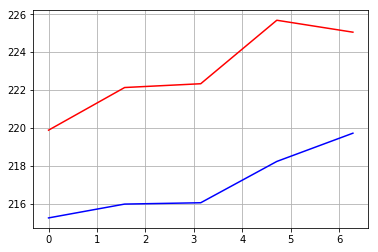

In [1398]:
windowsize = len(opendata.columns)-2
x = np.linspace(0,np.pi*2,windowsize)
y1 = opendata.ix[4732:4732,0:windowsize].values[0]
y2 = opendata.ix[len(opendata)-1:len(opendata)-1,0:windowsize].values[0]
plt.plot(x,y1,'b-')
plt.plot(x,y2,'r-')
plt.legend(loc=0)
plt.grid(True)

In [1394]:
delta = 1
sum = len(distdata[distdata['dist']<delta])
print('sum satisfied percent: '+str(sum/len(distdata)*100))
high = len(distdata[(distdata['dist']<delta)&(distdata['P1']>distdata['P0'])])
equal = len(distdata[(distdata['dist']<delta)&(distdata['P1']==distdata['P0'])])
low = len(distdata[(distdata['dist']<delta)&(distdata['P1']<distdata['P0'])])
highperc = high/sum * 100
equalperc = equal/sum * 100
lowperc = low/sum * 100
print('high  percentage:'+str(highperc))
print('equal percentage:'+str(equalperc))
print('low   percentage:'+str(lowperc))

sum satisfied percent: 22.738746318889355
high  percentage:54.024051803885285
equal percentage:0.18501387604070307
low   percentage:45.79093432007401


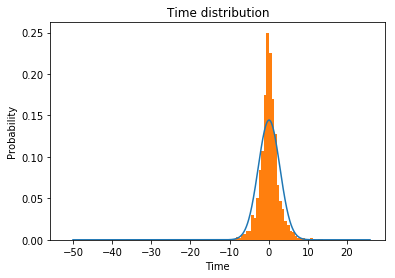

In [1395]:
sta = distdata.ix[0:,1:]
oneline = (sta['P1']-sta['P0'])/sta['P0']*100
oneline = oneline[oneline>-80]
mean = oneline.mean()
std = oneline.std()
def normfun(x,mu,sigma):
    pdf = np.exp(-((x - mu)**2)/(2*sigma**2)) / (sigma * np.sqrt(2*np.pi))
    return pdf
x = np.arange(-50,26,0.1)
y = normfun(x, mean, std)
plt.plot(x,y)
plt.hist(oneline, bins=100, rwidth=1, normed=True)
plt.title('Time distribution')
plt.xlabel('Time')
plt.ylabel('Probability')
plt.show()

In [1396]:
oneline.describe()

count    4753.000000
mean        0.102447
std         2.762135
min       -51.869159
25%        -1.063830
50%         0.071256
75%         1.319925
max        13.904959
dtype: float64

# 得出结论：
## 1、bar是固定时间段切割出的数据序列
## 2、bar切出的数据序列中，当前数据相对前数据的增长或减小的分布是随机的，类似抛硬币正反面
### 因此，在股市中任何长期的预测都是无法进行，即策略的长期盈利是不可能的，只能通过寻找短期时间段内概率的分布不均来进行投资或可获利